# Regression project: Real Estate Assessment Evaluation
Home valuation is key in real estate industry, and also the basis for mortgages in credit sector. Here we have to predict the estimated value of a property.

Data (RegressionSupervisedTrain.csv) consist of a list of features plus the resulting "parcelvalue", described in "Casedatadictionary.xlsx" file. Each row corresponds to a particular home valuation, and "transactiondate" is the date when the property was effectively sold. Properties are defined by "lotid", but be aware that one property can be sold more than once (it's not the usual case). Also notice that some features are sometimes missing, your model has to deal with it.

Note that you should not use "totaltaxvalue", "buildvalue" or "landvalue", because they are closely correlated with the final value to predict. There is a further member of the training set predictors which is not available in the test set and therefore needs removing. Using this data build a predictive model for "parcelvalue"

In your analysis, use the RMSE (Root Mean Squared Error) criterion for choosing any hyperparameters. Try a first quick implementation, then try to optimize hyperparameters.

For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence, have prepared also the necessary script to compute the MSE estimate on the test data once released.
Bonus: Try an approach to fill NA without removing features or observations, and check improvements.

You can follow those steps in your first implementation:
* Explore and understand the dataset. Report missing data
* Remove columns 'totaltaxvalue', 'buildvalue' or 'landvalue' from the training and testing set and also 'mypointer' from the training set
* As a simplified initial version, get rid of missing data by:
    - Removing features that have more than 40% of missing data in the training set (remember anything you remove from the training set must be removed form the testing set!) (HINT: data.dropna(axis=1, thresh=round(mypercentagevalid*len(data.index)) - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)
    - After that, removing observations that have missing data
* Create dummy variables for relevant categorical features (EXTENDED PROJECT ONLY)
* Build your model and test it on the same input data
* Assess expected accuracy using cross-validation
* Report which variable impacts more on results
* Prepare the code to run on a new input file and be able to report accuracy, following same preparation steps (missing data, dummies, etc)

Note that you should not use *totaltaxvalue*, *buildvalue *or *landvalue*, because they are closely correlated with the final value to predict.

You may want to iterate to refine some of these steps once you get performance results in step 5.

# 1. Load in libraries and data

In [150]:
# !source venv/bin/activate
# Basic libraries
import pandas as pd
import numpy as np
from scipy.stats import skew
import geopandas as gpd
from shapely.geometry import Point

# Sklearn
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, FunctionTransformer,MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_predict, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder

# Visualisation
import plotly_express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
from scipy.stats import linregress, zscore
# Basic functions

## Log transformation
def log_transform(x):
    #print(x)
    return np.log(x + 1)


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

Read in data

In [151]:
train = pd.read_csv("../data/Regression_Supervised_Train.csv")
test = pd.read_csv("../data/Regression_Supervised_Test.csv")

# Drop these features according to the instructions. mypointer is only present in the training set, so is dropped
drop_train = ['buildvalue', 'landvalue', 'mypointer', 'logerror', 'totaltaxvalue', 'lotid']
drop_test = ['buildvalue', 'landvalue', 'logerror', 'totaltaxvalue']

train = train.drop(drop_train, axis = 1)
test = test.drop(drop_test, axis = 1)
print(f"Training:{train.shape}, \n Test:{test.shape}")

Training:(24755, 42), 
 Test:(2746, 42)


## Missing values

In [152]:
percent_missing_train = train.isnull().sum() * 100 / len(train)
percent_missing_test = test.isnull().sum() * 100 / len(test)
missing_value_df = pd.DataFrame({
                                 'data_type':train.dtypes,
                                 'percent_missing_train': percent_missing_train,
                                      'percent_missing_test':percent_missing_test})
missing_value_df.sort_values(by = 'percent_missing_train', ascending = False)

,data_type,percent_missing_train,percent_missing_test
perimeterarea,float64,100.000000,100.000000
classbuild,float64,99.927287,100.000000
storytype,float64,99.773783,100.000000
basement,float64,99.773783,100.000000
totalarea,float64,99.749546,100.000000
fireplace,object,99.240557,99.854334
style,float64,99.058776,99.963583
material,float64,98.994143,99.927167
decktype,float64,97.123813,100.000000
taxdelinquencyyear,float64,96.420925,94.573926


## Handling Missing Data
The data set has many features with missing values. I use the following rules to deal with them:
#### 1. For features with $>$ 40\% missing observations and no intuitive way of inferring, I drop them.
- perimeterarea - drop
- classbuild - drop
- storytype - drop
- totalarea - drop
- style - drop
- material - drop
- finishedarea1st - drop feature
- transaction date - drop; No information on this feature

#### 2. For the following features, NAN most likely means that the feature is not present. For eg, missing observation of poolnum is most likely that there are no pools in the house; such observations have the corresponding poolarea as missing too. Hence, I impute 0/False/N for such features.
- basement - missing is 0
- unitnum - missing is 0
- dectype - missing is 0
- taxdelinquencyyear - make it to zero
- num34bath - missing is 0
- garagearea - make it zero
- pool area - make it zero
- gargenum - missing is 0
- poolnum - missing is 0
- tubflag - missing is False
- fireplace - missing is False - Can be dropped, all info captured by numfireplace
- taxdelinquencyflag - N if no delinquency

#### 3. The following features are imputed.
- aircond - missing is not 0 as the dictionary has the option for None. Impute mode
- quality - impute
- unitnum - impute
- heatingtype - missing is not 0 as the dictionary has the option for None. Impute mode
- lotarea - impute
- finishedarea - impute
- numfullbath - impute
- year - convert to age
- totaltaxvalue - impute
- finishedareaEntry - impute

#### 4. Will be dealt with later
- regioncode 
- neighbourhoodcode
- citycode

When missing indicates absence of feature - code it as 0 for the identified features.
- For the other features, I'll impute them in the pipeline.
- Numbath is a linear combo of num34bath and numfullbaths - can be dropped
- Fireplace - is redundant with numfireplaces

In [153]:
drop = ['perimeterarea', 'classbuild', 'storytype', 'totalarea', 'style',
        'material', 'transactiondate', 'finishedarea1st', 'fireplace', 'numbath']
train = train.drop(drop, axis = 1)
test = test.drop(drop, axis = 1)
print(f"Training:{train.shape}, \n Test:{test.shape}")


impute_zero = ['basement',  'decktype', 'num34bath', 'garagearea', 'poolarea', 'taxdelinquencyyear', 'garagenum', 'poolnum']
impute_false = ['tubflag'] # 
impute_no = ['taxdelinquencyflag']
present_year = 2020

def preprocess(df, present_year=2020):
    df = df.copy()  
    
    # Impute numeric with 0 
    df = df.assign(**{col: df[col].fillna(0) for col in impute_zero if col in df})
    
    # Impute boolean with False
    df = df.assign(**{col: df[col].fillna(False) for col in impute_false if col in df})
    
    # Impute string categorical with "N"
    df = df.assign(**{col: df[col].fillna("N") for col in impute_no if col in df})
    
    # Convert year columns to age of house
    for col in ['year', 'taxyear']:
        if col in df:
            df[col] = present_year - df[col]
    
    return df

# Apply to both
train = preprocess(train)
test = preprocess(test)

Training:(24755, 32), 
 Test:(2746, 32)


/var/folders/z1/06t5y7z11fz24b5p636_mqnr0000gn/T/ipykernel_7919/3537918820.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.assign(**{col: df[col].fillna(False) for col in impute_false if col in df})
/var/folders/z1/06t5y7z11fz24b5p636_mqnr0000gn/T/ipykernel_7919/3537918820.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.assign(**{col: df[col].fillna(False) for col in impute_false if col in df})


# 2. EDA

## Skew
Skew of the target variable is positive i.e. long right tails. 
Since we are using a linear model, it works best on symmetrically distributed data.
- Reduces influence of outliers
- Linearise non-linear relationships
- Deals with heteroskedasticity

Skew of target feature 10.924666213432062
Skew of target feature after log transformation 0.12866162749355226


Text(0.5, 1.0, 'Log(Parcelvalue)')

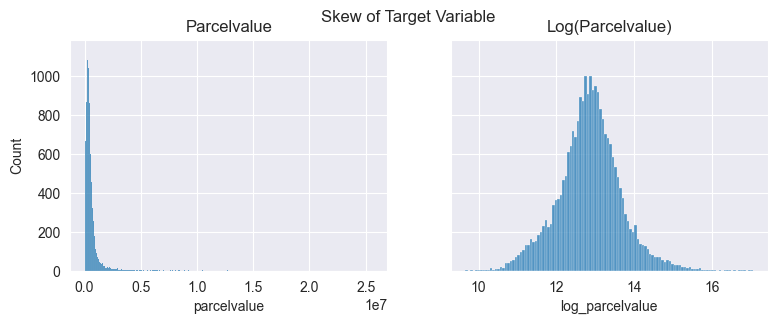

In [154]:
# Calculate skew
print(f"Skew of target feature {skew(train.parcelvalue)}") # 10.924666213432062

# The target has a positive skew. Log transform the variable to get a more symmetrical distribution
train['log_parcelvalue'] = np.log(train['parcelvalue'])

# Calculate skew and visualize
print(f"Skew of target feature after log transformation {skew(train.log_parcelvalue)}")

# Histograms
fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
fig.suptitle('Skew of Target Variable')
## Original
sns.histplot(ax=axes[0], x = train.parcelvalue)
axes[0].set_title('Parcelvalue')
## Log transformed
sns.histplot(ax=axes[1], x = train.log_parcelvalue)
axes[1].set_title('Log(Parcelvalue)')

Get required columns
See data dictionary for the feature definitions.

In [155]:
categorical = ['aircond', 'qualitybuild', 'decktype', 'tubflag', 'heatingtype',
               'taxdelinquencyflag', 'countycode', 'countycode2','regioncode',
                'neighborhoodcode', 'citycode', 'unitnum']

numerical =   ['basement', 'numbedroom', 'finishedarea',
               'finishedareaEntry', 'numfireplace', 'numfullbath', 'garagenum', 
               'garagearea', 'lotarea',  'poolarea', 'roomnum',
               'num34bath', 'year', 'numstories', 'taxyear',
               'taxdelinquencyyear', 'poolnum']

Skew of numerical features. 12 out of 19 features have a skew greater than 1. Hence, it is best to log transform all numerical features

In [18]:
# Calculate skew
skew_df = pd.DataFrame(train[numerical].skew(skipna = True)).abs()
print(f"% Features with skew greater than 1 is {skew_df[skew_df[0] > 1]}")

% Features with skew greater than 1 is                             0
basement             1.282222
finishedarea         3.534346
finishedareaEntry    3.140212
numfireplace         2.423594
numfullbath          1.726680
garagenum            3.793743
garagearea           1.235914
lotarea             10.063577
poolarea             1.021702
num34bath           13.861755
taxdelinquencyyear   2.025671


## Plots
Now I look at the joint distribution of the features and target variable. Since the task is to use linear regression, I also fit the OLS line of best fit with $CI = 95\%$

Looking at the regression plots, I identify the following candidates for polynomial transformation: ['finishedarea', 'finishedareaEntry' ]

Most features do exhibit a linear relationship.
Notes:
1. It doesn't make sense to treat longitude and latitude as affecting the target in a linear manner. I will use a clustering algorithm and use the cluster labels instead of lat/long in the model.
2. roomnum and lotarea have a lot of zeroes which doesn't make sense - these are likely to have been miscoded or where the interpretation is wrong - Deal with them in feature engineering.

## Histograms - Numerical features

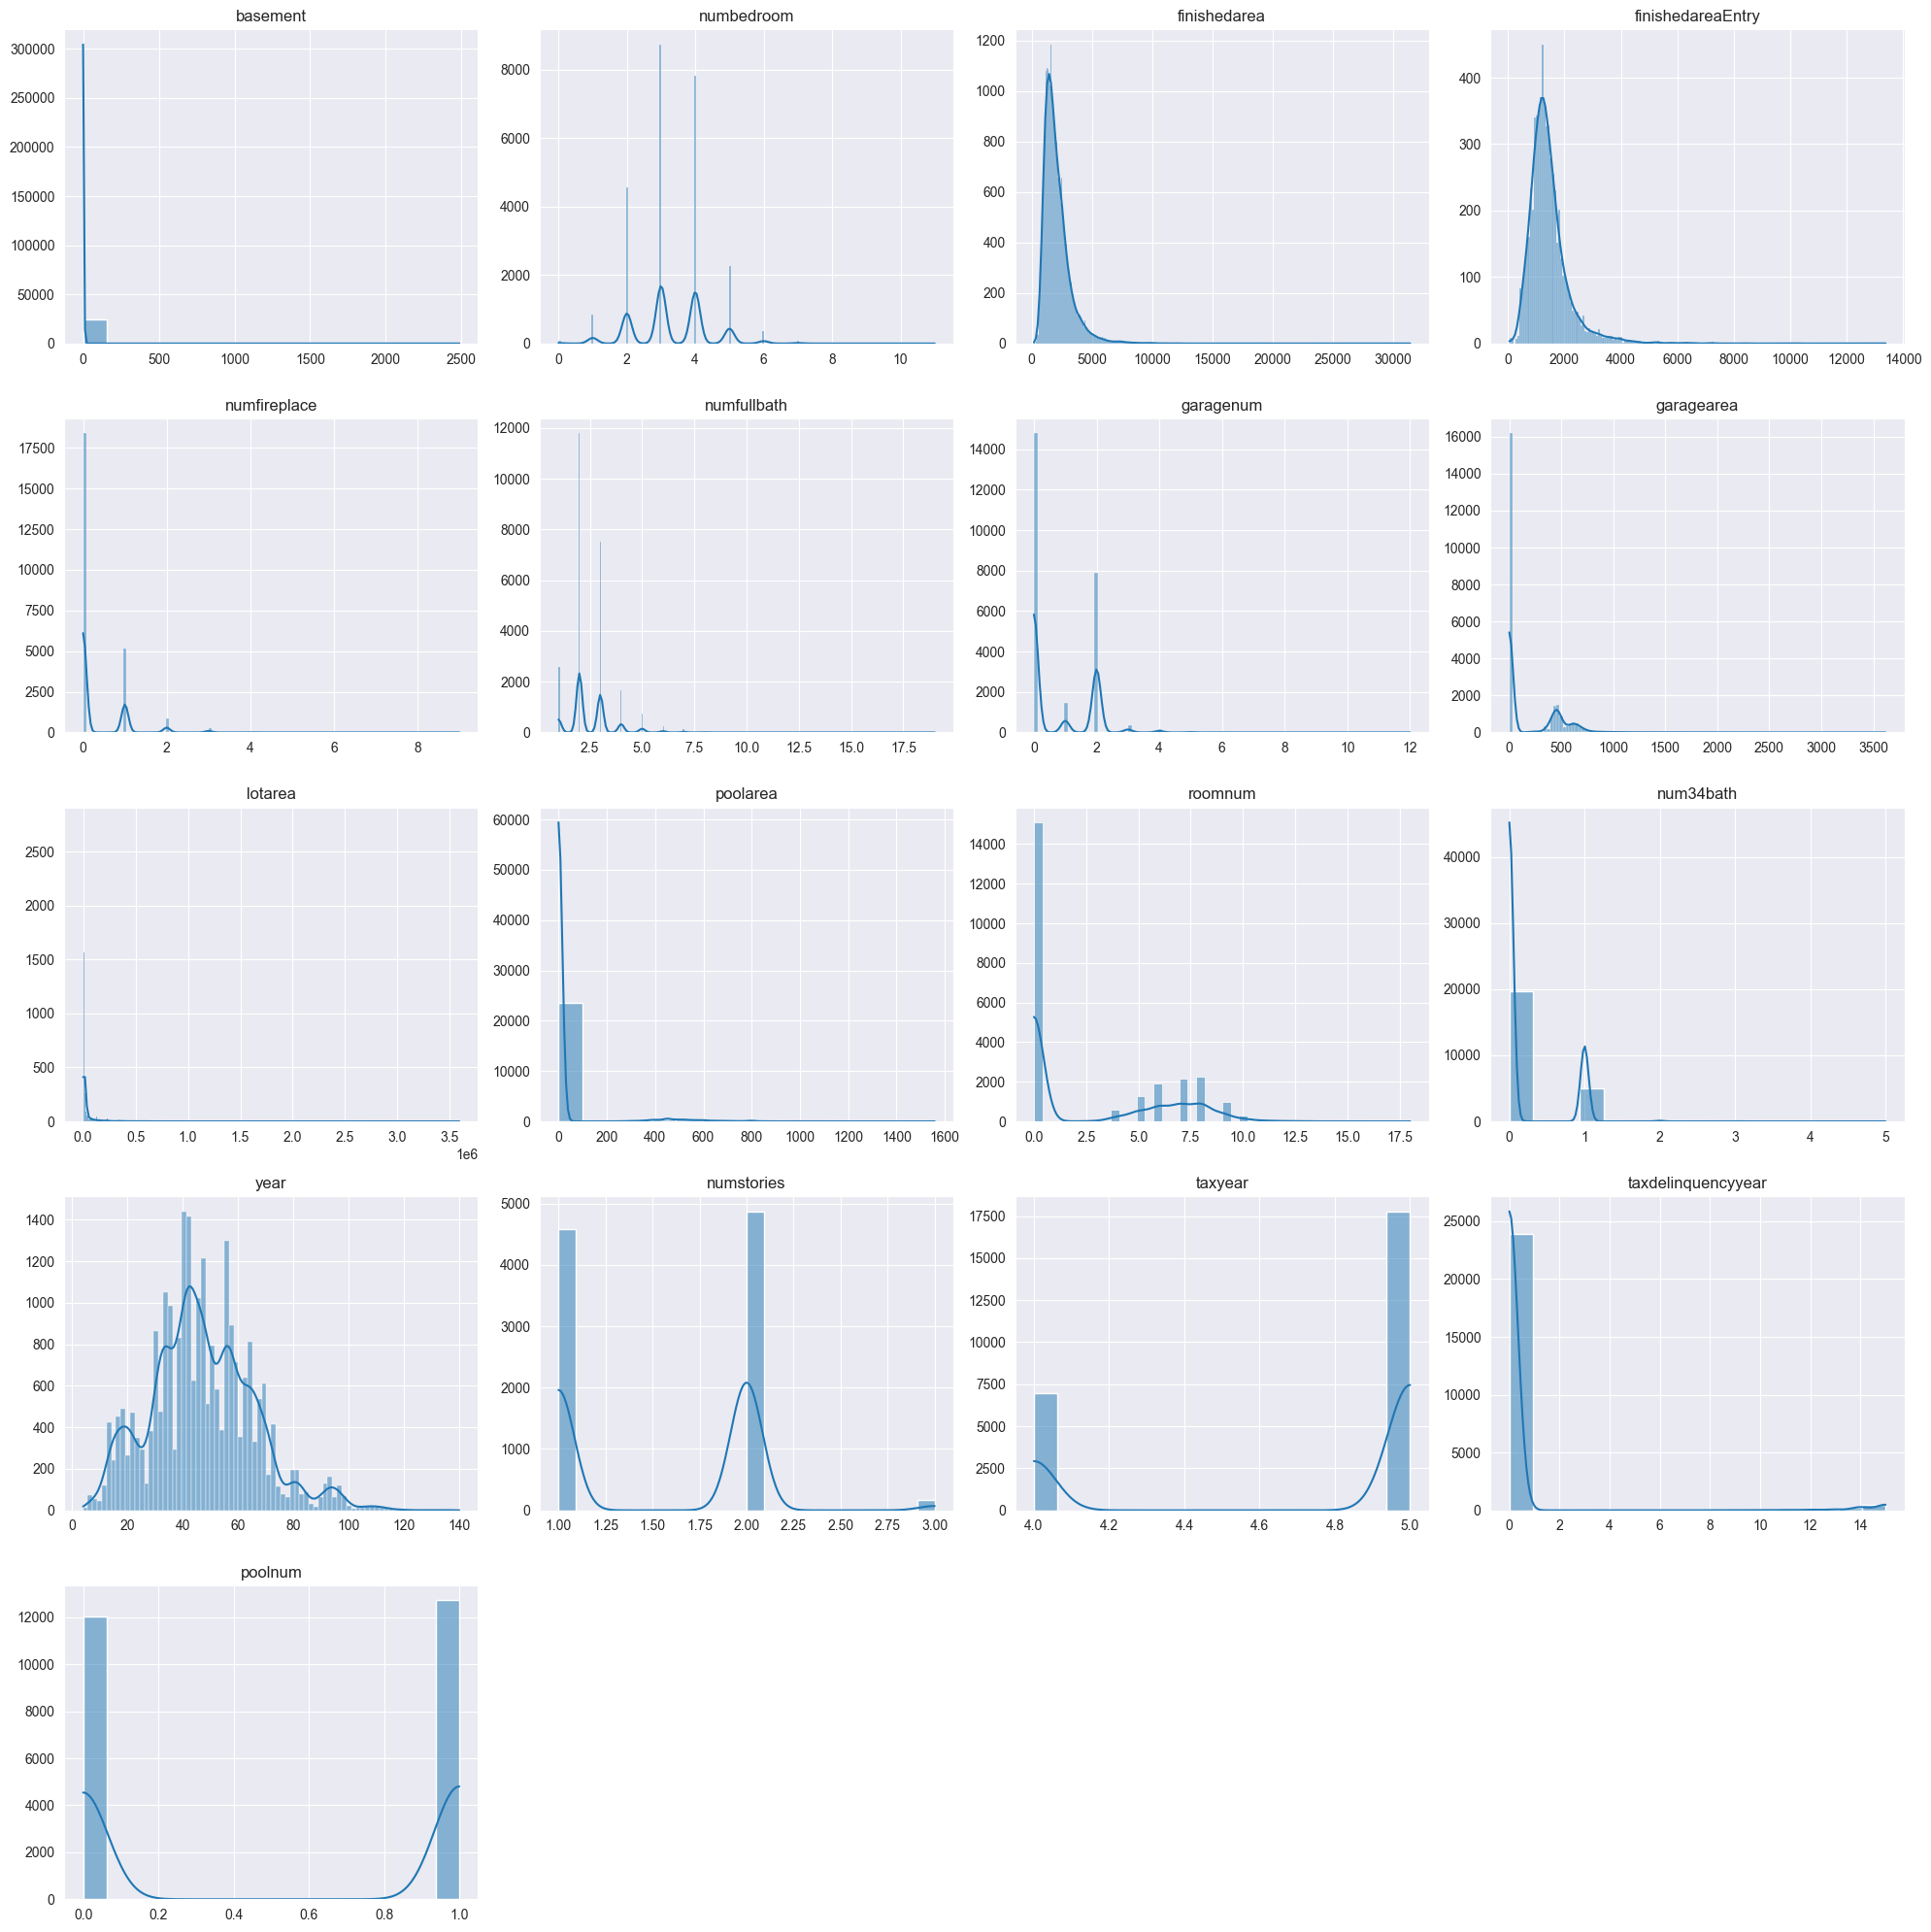

In [156]:
n_cols = 4
n_feats = len(numerical)
n_rows = math.ceil(n_feats / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

axes = axes.flatten()  

for i, feat in enumerate(numerical):
    sns.histplot(train[feat], ax=axes[i], kde=True)
    axes[i].set_title(feat)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

## Histograms - Categorical features
- Region and county codes have very high cardinality - leave them out from the simple model for now.

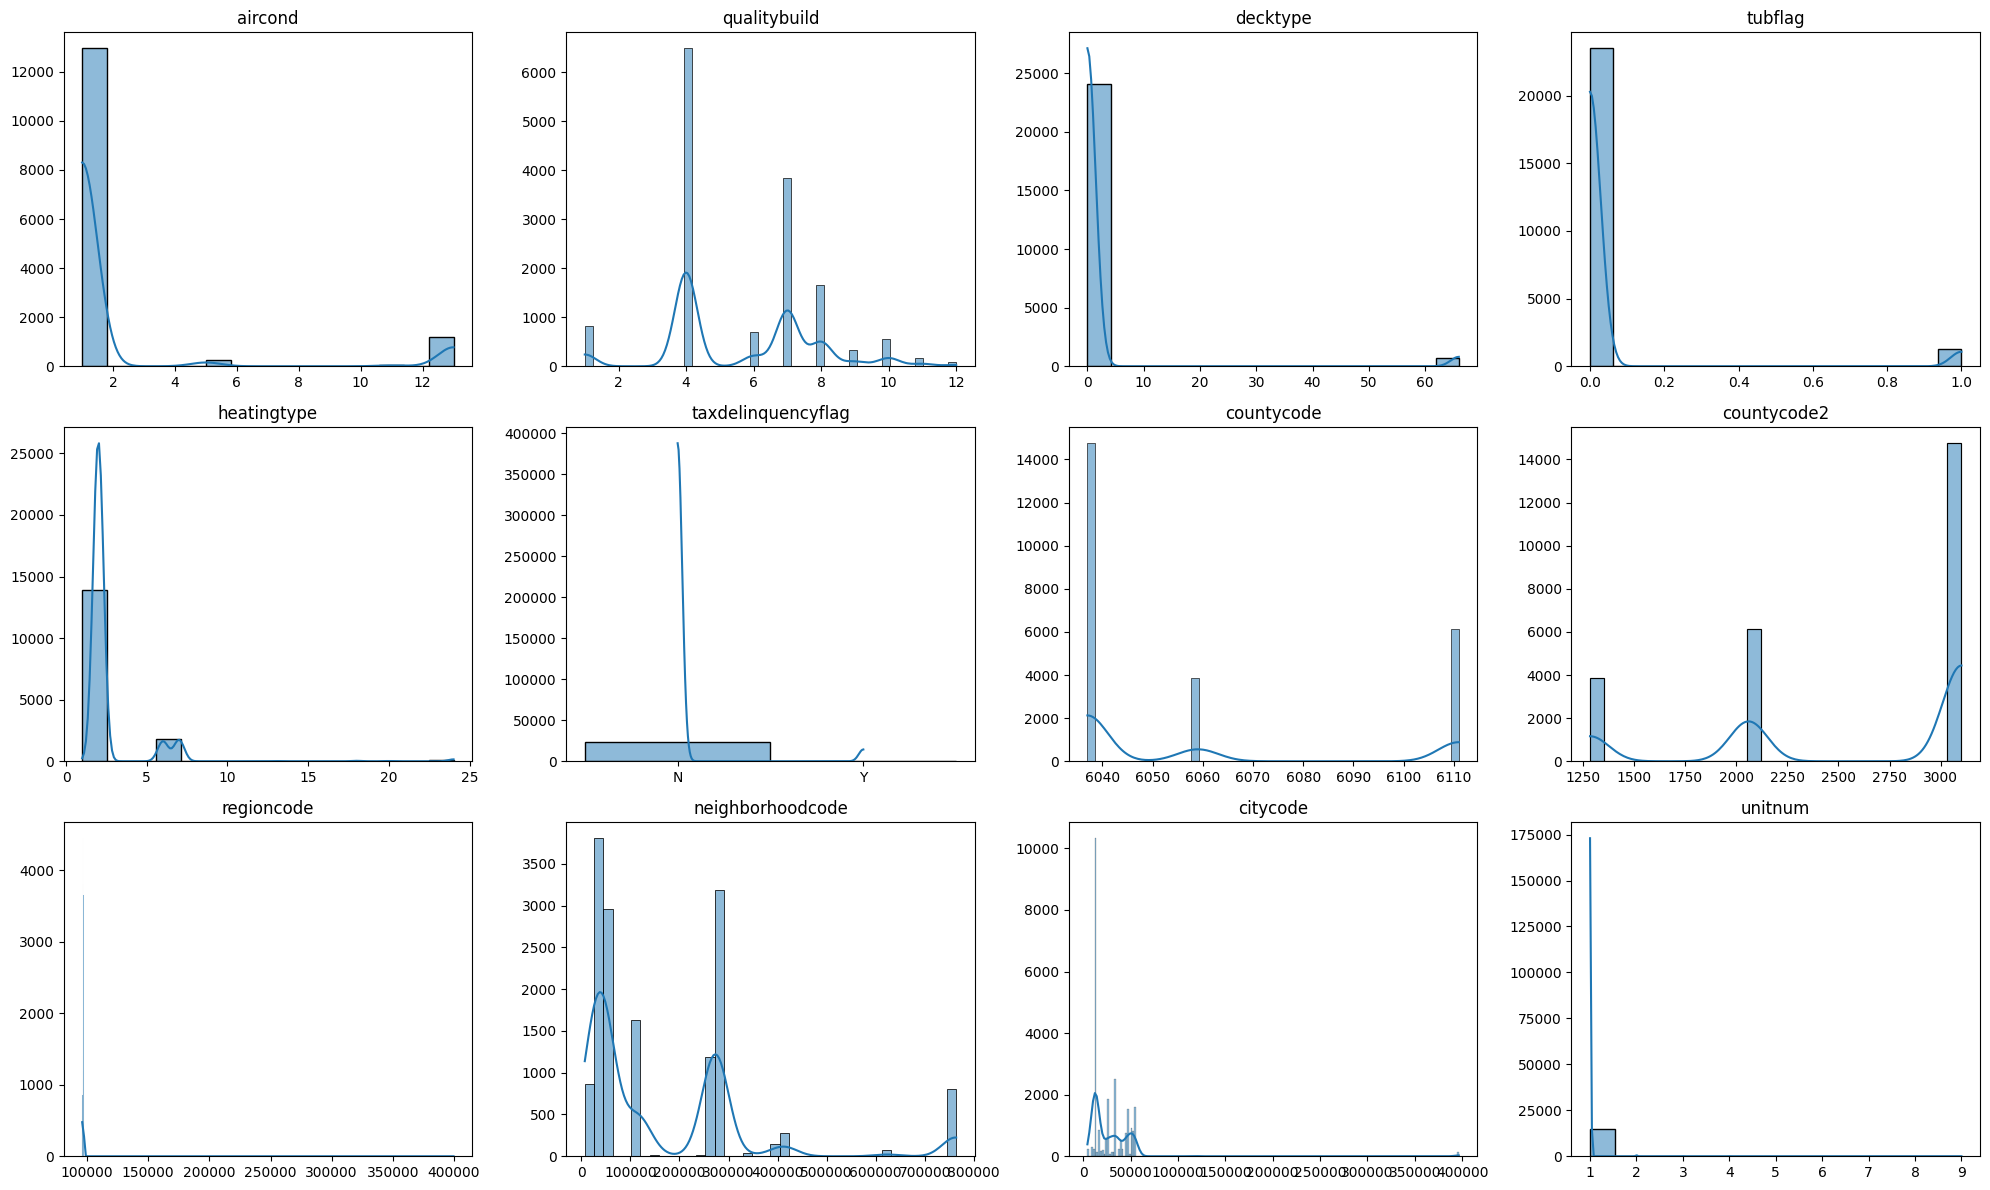

In [54]:
n_cols = 4
n_feats = len(categorical)
n_rows = math.ceil(n_feats / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

axes = axes.flatten()  

for i, feat in enumerate(categorical):
    sns.histplot(train[feat], ax=axes[i], kde=True)
    axes[i].set_title(feat)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

## Scatterplot

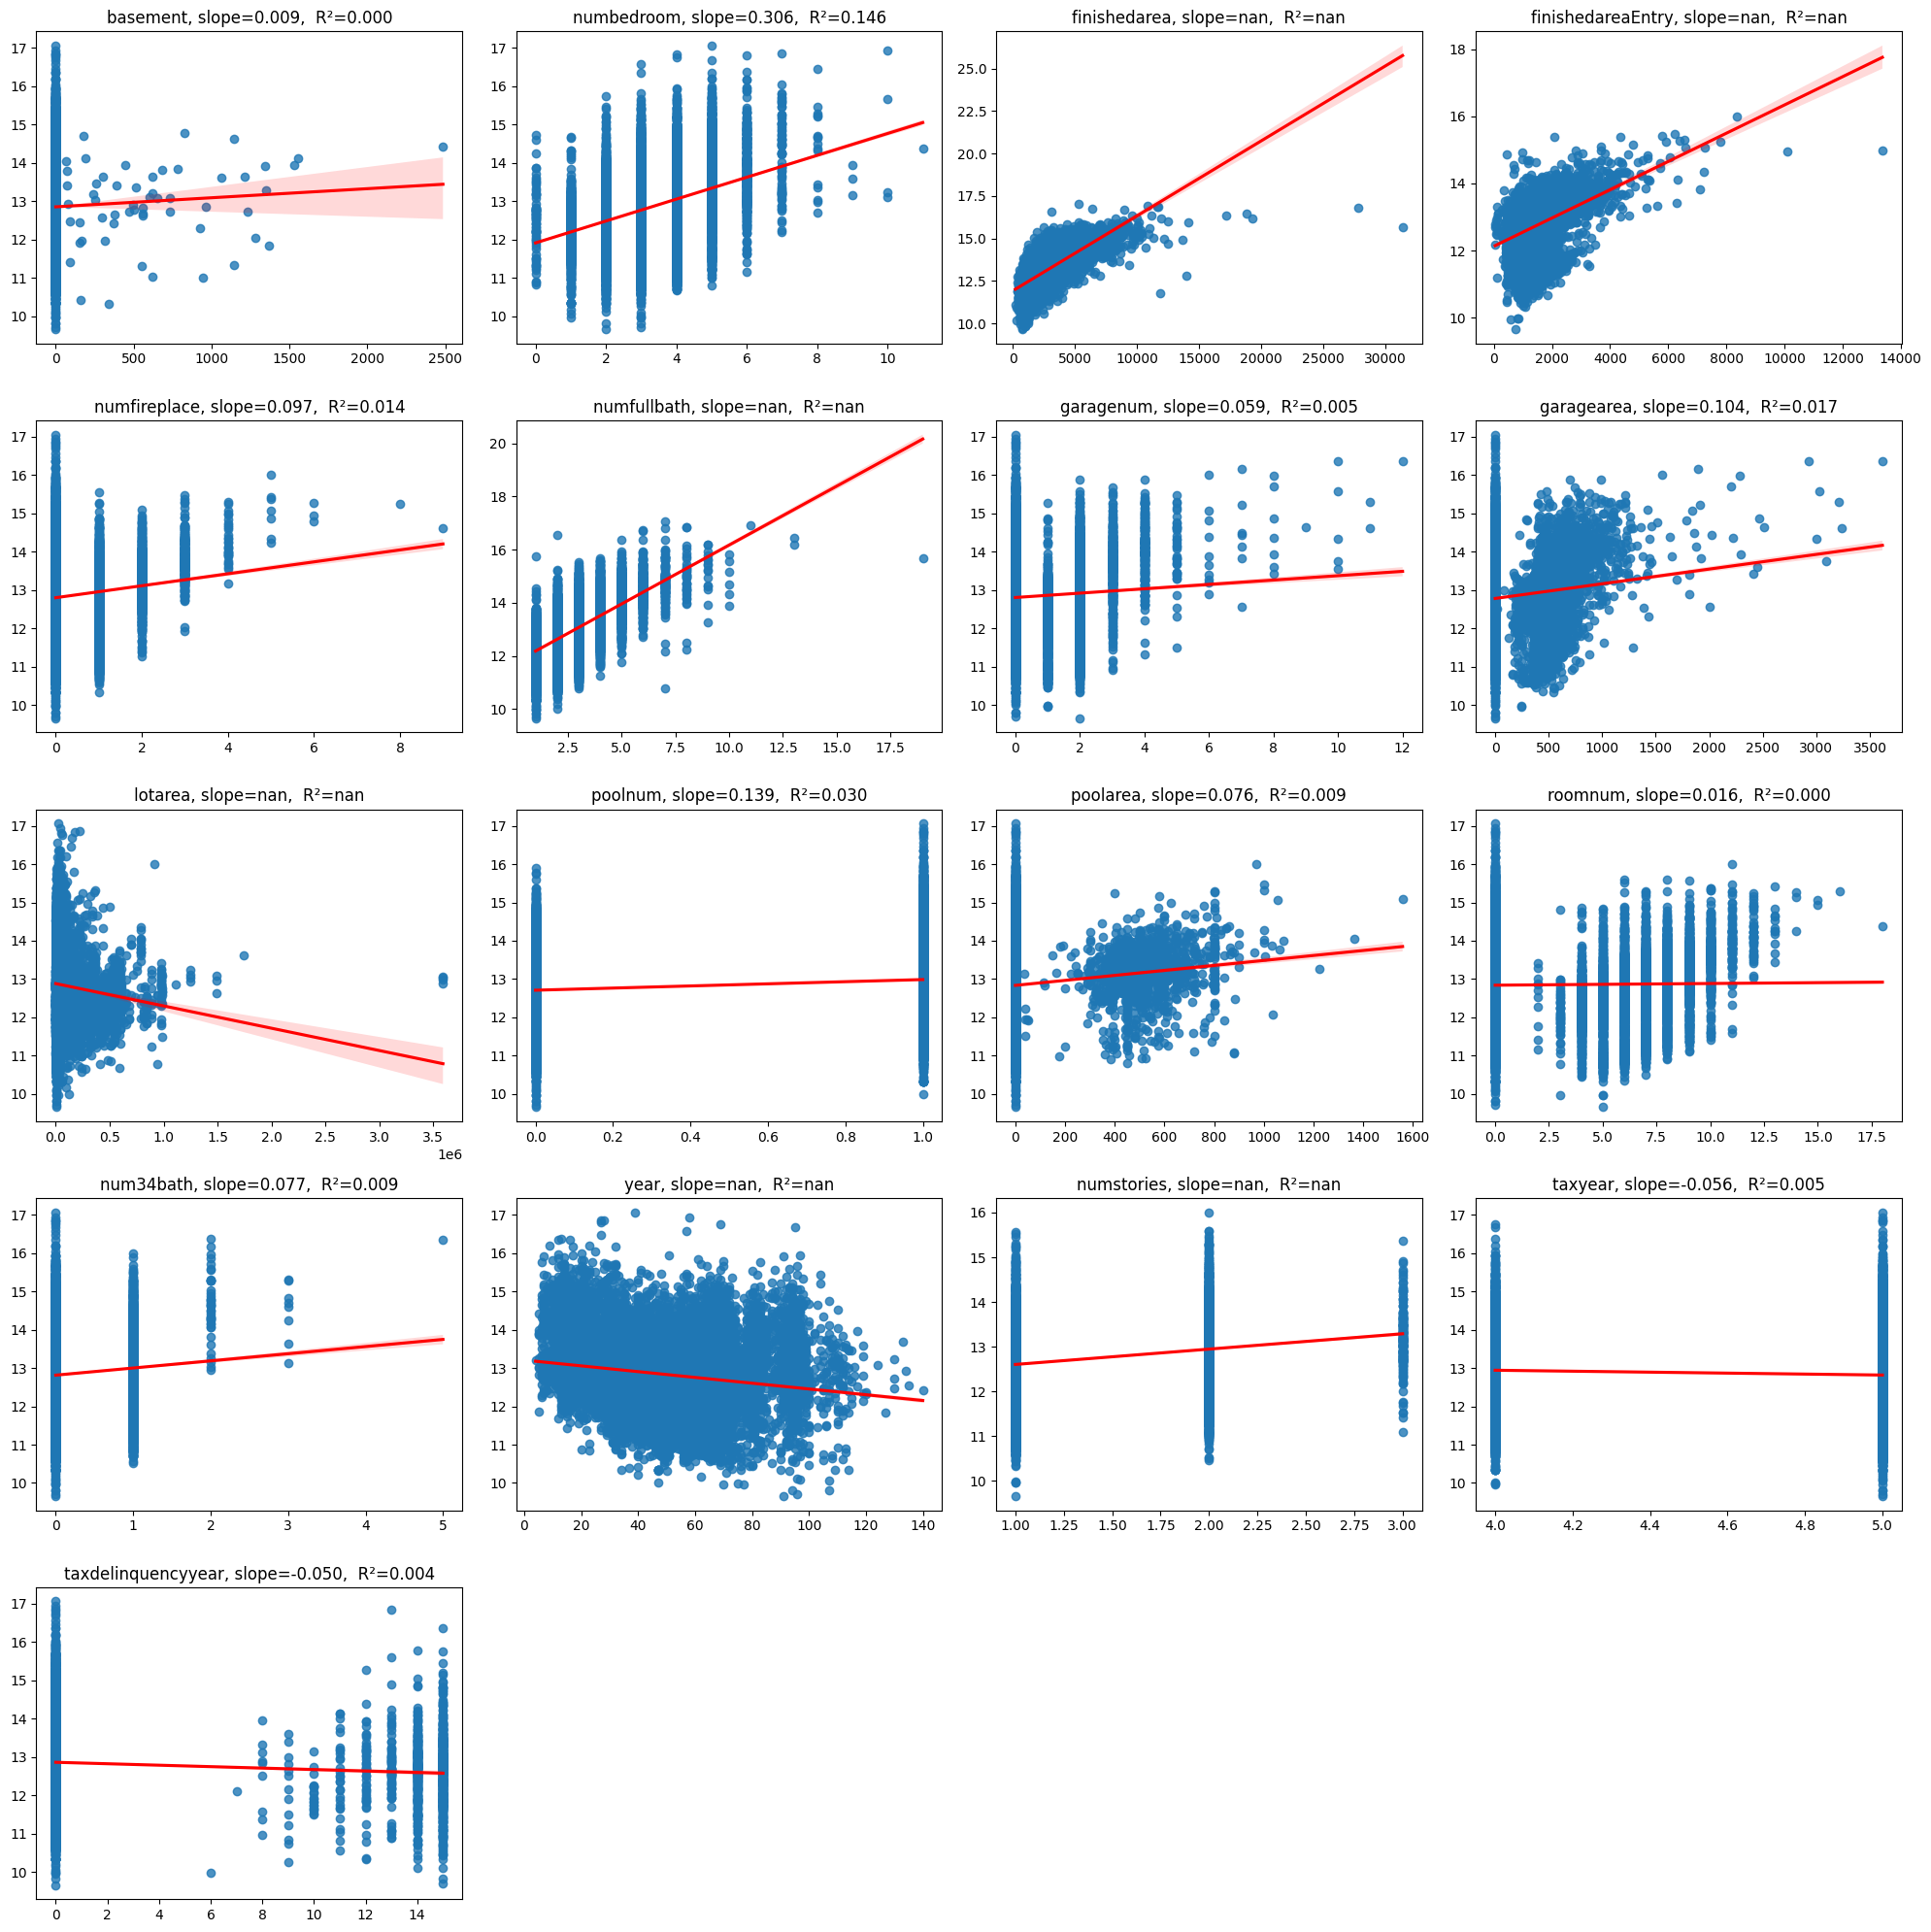

In [9]:
train_dropped_nas = train.dropna(subset= numerical,how = 'any',axis = 0)

n_cols = 4
n_feats = len(numerical)
n_rows = math.ceil(n_feats / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

axes = axes.flatten()  

for i, feat in enumerate(numerical):
    sns.regplot(ax = axes[i], x = train[feat], y= train['log_parcelvalue'], ci = 95, line_kws = {'color':'red'})
    slope, intercept, r_value, p_value, std_err = linregress(zscore(train[feat]), train['log_parcelvalue'])

    axes[i].set_title(f"{feat}, slope={slope:.3f},  R²={r_value**2:.3f}")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Hide extra 
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

# 3.  Fitting a simple model

Run a baseline model with no feature engineering and leaving out high cardinality categorical features.

In [165]:
categorical_simple = [
    'aircond', 'qualitybuild', 'decktype',
    'tubflag', 'heatingtype',
    'taxdelinquencyflag', 'unitnum']

numerical_simple =   [
    'basement', 'numbedroom', 'finishedarea',
    'finishedareaEntry', 'numfireplace', 'numfullbath', 'garagenum',
    'garagearea', 'lotarea', 'poolnum', 'poolarea', 'roomnum',
   'num34bath', 'year', 'numstories', 'taxyear',
   'taxdelinquencyyear'
]

In [166]:
X_simple = train.drop(['parcelvalue', 'log_parcelvalue', 'longitude', 'latitude',
                        'countycode', 'countycode2', 'regioncode',
                          'neighborhoodcode', 'citycode'], axis = 1)
y = train['log_parcelvalue']
print(f"Features:{X_simple.shape}, \n Target:{y.shape}")

Features:(24755, 24), 
 Target:(24755,)


Initiate the regression pipeline, assign the appropriate features to the appropriate preporcessors

In [54]:
log_tranformer = FunctionTransformer(log_transform)

poly_features = ['finishedarea', 'finishedareaEntry' ]

numeric_transformer = Pipeline(
             steps = [
                      ("imputer", SimpleImputer(strategy = 'median')),
                      ("log", log_tranformer),
                #       ("poly", PolynomialFeatures(degree = 3)),
                      ("scaler", StandardScaler())
                      ])

poly_transformer = Pipeline(
             steps = [
                      ("imputer", SimpleImputer(strategy = 'median')),
                      ("log", log_tranformer),
                      ("poly", PolynomialFeatures(degree = 3)),
                      ("scaler", StandardScaler())
                      ])

categorical_transformer = Pipeline(
             steps = [ ("imputer", SimpleImputer(strategy = "most_frequent")),
                        ( "ohe", OneHotEncoder(
                                                handle_unknown='ignore',
                                                sparse_output=False))])

# preprocessor pipeline combining both:
preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numerical_simple),
        ("poly", poly_transformer, poly_features),
        ("cat", categorical_transformer, categorical_simple),
        ])

# Define the pipeline for preprocessing and the classifier.
regression_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', LinearRegression())])

# Check structure of pipeline:
regression_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   FunctionTransformer(func=<function log_transform at 0x12a275f70>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['basement', 'numbedroom',
                                                   'finishedarea',
                                                   'finishedareaEntry',
                                                   'numfireplace',
                                                   'numfullbath', 'garagenum',
                                                   'garagearea', 'lo...
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['finishedarea',
                                                   'finishedareaEntry']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['aircond', 'qualitybuild',
                                                   'decktype', 'tubflag',
                                                   'heatingtype',
                                                   'taxdelinquencyflag',
                                                   'unitnum'])])),
                ('regression', LinearRegression())])

## Model performance
- I compare four models - Linear regression, and 3 regularised models. 
- All models perform 'similarly' on both train and test sets.
- No signficant gain from regularisation - linear regression is not overfitting too much and has 'good' amount of bias.

### Simple Linear Regression
### Kaggle Private Score - 659,364
### In-sample RMSE: 0.569816067625646

In [58]:
# Get cross validated predictions
y_hat_in = cross_val_predict(regression_pipeline, X_simple, y, cv = 10)

# Check in sample RMSE
print(f"RMSE = {root_mean_squared_error(y,y_hat_in)}")

# Fit model
regression_pipeline.fit(X_simple, y)

# Predict on test set and undo the logarithmic transformation of target feature
y_hat_test = np.exp(regression_pipeline.predict(test[X_simple.columns]))

# Create datafram of predictions
test_predictions_submit = pd.DataFrame({"lotid": test["lotid"], "parcelvalue": y_hat_test})

# Dataframe to csv
test_predictions_submit.to_csv("test_predictions_linreg.csv", index = False)

RMSE = 382714470.3178604


## Regularisation
### L1: Lasso
### Kaggle Private Score: 662,537
### In-sample RMSE: 0.5697383343865633, alpha = 0.001

In [53]:
# Define the pipeline for preprocessing and the classifier.
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Lasso', Lasso())])

# Check structure of pipeline:
lasso_pipeline

param_grid = {

                'Lasso__alpha' : [0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.5, 1, 5, 10, 25, 50, 100]
                     } 
# Initiate grid search object
grid_search_lasso = GridSearchCV(lasso_pipeline,
                           param_grid,
                           cv = 5,
                           scoring = "neg_root_mean_squared_error",
                           verbose = 10)
# Fit the grid search
grid_search_lasso.fit(X_simple, y)

# Get best parameters
print(grid_search_lasso.best_params_)

# Get in sampple predictions and RMSE
y_hat_in_lasso = grid_search_lasso.predict(X_simple)

# Check in sample RMSE
print(f"RMSE = {root_mean_squared_error(y, y_hat_in_lasso)}") # RMSE = 0.5479937081116162 (log values)

y_hat_test_lasso = np.exp(grid_search_lasso.predict(test[X_simple.columns]))
test_predictions_submit = pd.DataFrame({"lotid": test["lotid"], "parcelvalue": y_hat_test_lasso})
test_predictions_submit.to_csv("test_predictions_lasso.csv", index = False)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV 1/5; 1/13] START Lasso__alpha=0.001.........................................
[CV 1/5; 1/13] END .........Lasso__alpha=0.001;, score=-0.570 total time=   0.9s
[CV 2/5; 1/13] START Lasso__alpha=0.001.........................................
[CV 2/5; 1/13] END .........Lasso__alpha=0.001;, score=-0.564 total time=   0.9s
[CV 3/5; 1/13] START Lasso__alpha=0.001.........................................
[CV 3/5; 1/13] END .........Lasso__alpha=0.001;, score=-0.573 total time=   0.8s
[CV 4/5; 1/13] START Lasso__alpha=0.001.........................................
[CV 4/5; 1/13] END .........Lasso__alpha=0.001;, score=-0.570 total time=   0.9s
[CV 5/5; 1/13] START Lasso__alpha=0.001.........................................
[CV 5/5; 1/13] END .........Lasso__alpha=0.001;, score=-0.575 total time=   0.9s
[CV 1/5; 2/13] START Lasso__alpha=0.005.........................................
[CV 1/5; 2/13] END .........Lasso__alpha=0.005;,

### L2: Ridge
### Kaggle Private Score: 660,176
### In-sample RMSE: 0.5684734992787926, alpha = 5

In [57]:
# Define the pipeline for preprocessing and the classifier.
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Ridge', Ridge())])

# Check structure of pipeline:
ridge_pipeline

param_grid = {
                'Ridge__alpha' : [0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.5, 1, 5, 10, 25, 50, 100]}# 5 is chosen
grid_search_ridge = GridSearchCV(ridge_pipeline,
                           param_grid,
                           cv=5,
                           scoring = "neg_root_mean_squared_error",
                           verbose = 10)
# Fit the grid search
grid_search_ridge.fit(X_simple, y)

# Get best parameters
print(grid_search_ridge.best_params_)

# Get in sampple predictions and RMSE
y_hat_in_ridge = grid_search_ridge.predict(X_simple)

# Check in sample RMSE
print(f"RMSE = {root_mean_squared_error(y, y_hat_in_ridge)}")

y_hat_test_ridge = np.exp(grid_search_ridge.predict(test[X_simple.columns]))
test_predictions_submit = pd.DataFrame({"lotid": test["lotid"], "parcelvalue": y_hat_test_ridge})
test_predictions_submit.to_csv("test_predictions_ridge.csv", index = False)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV 1/5; 1/13] START Ridge__alpha=0.001.........................................
[CV 1/5; 1/13] END .........Ridge__alpha=0.001;, score=-0.573 total time=   0.3s
[CV 2/5; 1/13] START Ridge__alpha=0.001.........................................
[CV 2/5; 1/13] END .........Ridge__alpha=0.001;, score=-0.569 total time=   0.2s
[CV 3/5; 1/13] START Ridge__alpha=0.001.........................................
[CV 3/5; 1/13] END .........Ridge__alpha=0.001;, score=-0.577 total time=   0.2s
[CV 4/5; 1/13] START Ridge__alpha=0.001.........................................
[CV 4/5; 1/13] END .........Ridge__alpha=0.001;, score=-0.573 total time=   0.2s
[CV 5/5; 1/13] START Ridge__alpha=0.001.........................................
[CV 5/5; 1/13] END .........Ridge__alpha=0.001;, score=-0.581 total time=   0.2s
[CV 1/5; 2/13] START Ridge__alpha=0.005.........................................
[CV 1/5; 2/13] END .........Ridge__alpha=0.005;,

### ElasticNet
### Kaggle Private Score: 661,815
### In-sample performance: 0.5689273730098059

In [63]:
from sklearn.linear_model import ElasticNet


elastic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ElasticNet', ElasticNet(max_iter=10000))
])

param_grid = {
    'ElasticNet__alpha':    [0.001, 0.01, 0.1, 1, 10],    
    'ElasticNet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9] 
}

# Initiate grid search object
grid_search_elastic = GridSearchCV(elastic_pipeline,
                           param_grid,
                           cv=5,
                           scoring = "neg_root_mean_squared_error",
                           verbose = 10)
# Fit the grid search
grid_search_elastic.fit(X_simple, y)

# Get best parameters
print(grid_search_elastic.best_params_)

# Get in sampple predictions and RMSE
y_hat_in_ridge = grid_search_elastic.predict(X_simple)

# Check in sample RMSE
print(f"RMSE = {root_mean_squared_error(y, y_hat_in_ridge)}") # RMSE = 0.5164723492805274 (log values)

y_hat_test_ridge = np.exp(grid_search_elastic.predict(test[X_simple.columns]))
test_predictions_submit = pd.DataFrame({"lotid": test["lotid"], "parcelvalue": y_hat_test_ridge})
test_predictions_submit.to_csv("test_predictions_elastic.csv", index = False)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5; 1/25] START ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.1..........
[CV 1/5; 1/25] END ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.1;, score=-0.573 total time=   1.7s
[CV 2/5; 1/25] START ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.1..........
[CV 2/5; 1/25] END ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.1;, score=-0.569 total time=   2.4s
[CV 3/5; 1/25] START ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.1..........
[CV 3/5; 1/25] END ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.1;, score=-0.576 total time=   3.0s
[CV 4/5; 1/25] START ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.1..........
[CV 4/5; 1/25] END ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.1;, score=-0.573 total time=   2.5s
[CV 5/5; 1/25] START ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.1..........
[CV 5/5; 1/25] END ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.1;, score=-0.581 total time=   2.8s
[CV 1/5; 2/25] STA

# 4 Feature Engineering
- I did not use some of the features before.
- Some features do not make sense, fx the roomnum = 0 with numbedroom != 0 I'll recode them.
- Latitude and longitude were not used - see if we can derive some useful information from them.
- Inpsect the city and region code variables.

## Latitude and Longitude
- See if there are clustering methods to derive some useful features
- There seems to be a few hotspots of high value houses but no clear visual trend.

/Users/gnlm/Desktop/ds_projects/housing/Housing-Prices-Prediction/.venv/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(0.5, 1.0, 'Los Angeles, Ventura & Orange Counties: Real Estate')

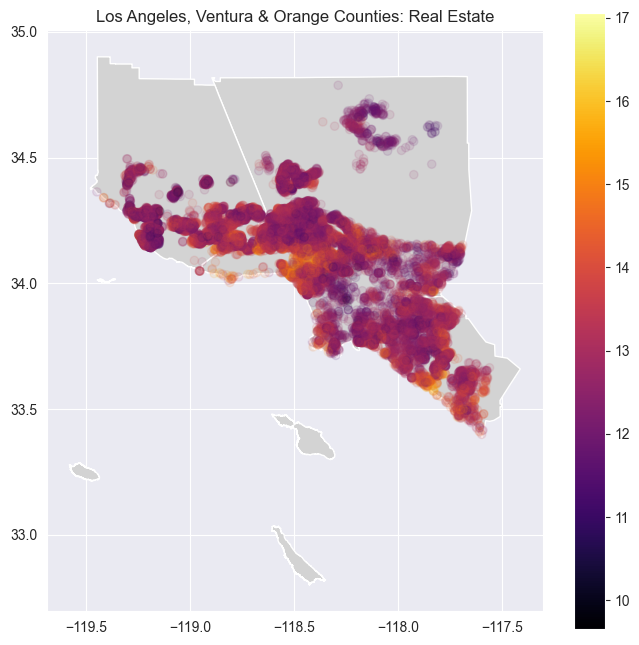

In [167]:
# Latitude and longitude are multiplied by $10^6$ in the datasets
for df in [train, test]:
    df['longitude'] = df['longitude']/10**6
    df['latitude'] = df['latitude']/10**6

# Load the county map. County map downloaded from https://gis.data.ca.gov/datasets/8713ced9b78a4abb97dc130a691a8695_0/explore?filters=eyJDT1VOVFlfTkFNRSI6WyJMb3MgQW5nZWxlcyJdfQ%3D%3D&location=34.524112%2C-117.443958%2C6.94
cali_map = gpd.read_file("../data/California_County_Boundaries/cnty19_1.shp")

# Get subset
geo_data = train[['log_parcelvalue', 'latitude', 'longitude']]

# Declare CRS
crs = {'init': 'epsg:4326'}

# Create geometry points using lat and long
geometry = [Point(xy) for xy in zip(geo_data['longitude'], geo_data['latitude'])]

# Make a geographic dataframe
geo_df = gpd.GeoDataFrame(geo_data,
                          crs = crs,
                          geometry = geometry)

# Plot the houses on the county map
fig, ax = plt.subplots(figsize = (8, 8))
cali_map.to_crs(epsg=4326).plot(ax = ax, color = 'lightgrey')
geo_df.plot(ax = ax, alpha = 0.1, column = 'log_parcelvalue', legend = True, cmap = 'inferno')
ax.set_title('Los Angeles, Ventura & Orange Counties: Real Estate')

## Create grids around the points, similar to GIS. 
- We can use this feature to one-hot encode.
- Visually, these grids make more sense than using K-means

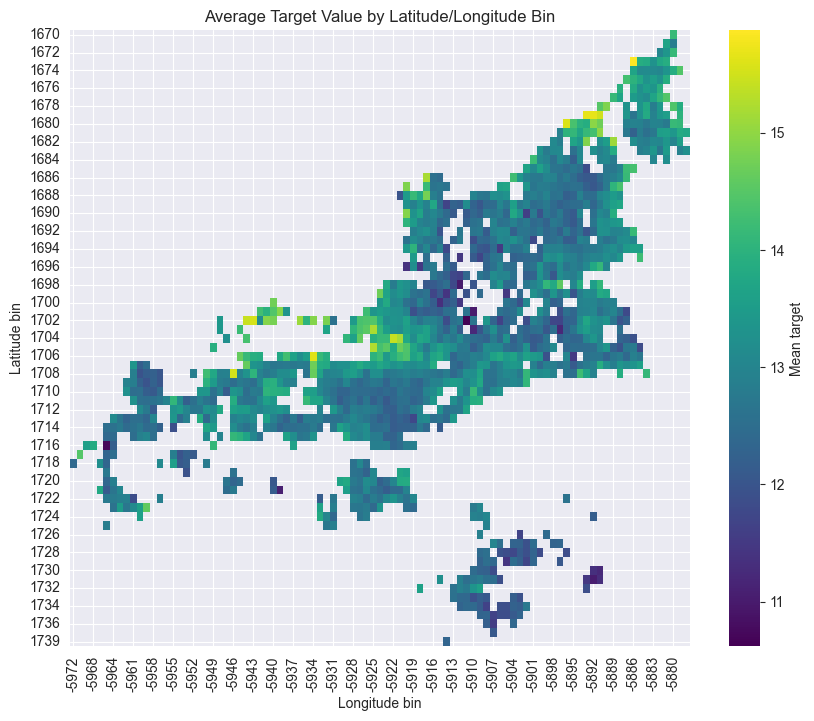

In [168]:
# Try different values for grid sizes - 50 looks to capture enough observations
for df in [train,test]:
    df['lat_bin'] = (df['latitude'] * 50).round().astype(int)
    df['lon_bin'] = (df['longitude'] * 50).round().astype(int)
    df['geo_bin'] = df['lat_bin'].astype(str) + '_' + df['lon_bin'].astype(str)

lat_lon_bins = train.groupby(['lat_bin', 'lon_bin']).agg(mean_log_parcel_value = ('log_parcelvalue', 'mean')).reset_index()
lat_lon_bins = lat_lon_bins.pivot(index = 'lat_bin',
                                  columns = 'lon_bin',
                                  values = 'mean_log_parcel_value')

# Visualise bins:
plt.figure(figsize=(10, 8))
sns.heatmap(lat_lon_bins,
             cmap='viridis',
               cbar_kws={'label': 'Mean target'})

plt.title('Average Target Value by Latitude/Longitude Bin')
plt.xlabel('Longitude bin')
plt.ylabel('Latitude bin')
plt.show()

## Creating New Features
I create the following features. These are mere subjective assessments of "relevant" features.

- $Average\ room\ size = (Total\ finished\ area)/(Bedrooms)$
- $Bed-Bathroom-Ratio = (Bathrooms)/(Bedrooms )$
- Roomnums - doesnt make sense that there are so many zeros -> Impute with median grouped by 'numbedroom'.
    - Cases where num_rooms = 0 are treated as missing. Missing room counts are imputed using the median number of rooms conditional on the number of bedrooms, computed from the training set only.
- For lotarea, create a has lotarea indiciator.
    - Values of lotarea = 0 were treated as invalid (properties cannot have zero land area). These were set to missing, and a companion feature has_lot was created (1 = lot present, 0 = no lot). Missing values were imputed using medians learned from the training data.

In [175]:
for df in [train,test]:
    df['roomnum'] = df['roomnum'].replace(0, np.nan)
    df['avg_room_size'] = df['finishedarea']/df['roomnum']
    df['bed_bath_ratio'] = (df['num34bath'] + df['numfullbath'])/df['roomnum']

# Numrooms = 0 doesnt make sense - impute based on numbedrooms
median_rooms_by_bed = train.groupby('numbedroom')['roomnum'].median()

# create imputed roomnum
train['roomnum_imputed'] = train['numbedroom'].map(median_rooms_by_bed)
test['roomnum_imputed'] = test['numbedroom'].map(median_rooms_by_bed)
# fill nan with imputed
train['roomnum'] = train['roomnum'].fillna(train['roomnum_imputed'])
test['roomnum'] = test['roomnum'].fillna(test['roomnum_imputed'])

train = train.drop(columns = ['roomnum_imputed'], axis = 1)
test = test.drop(columns = ['roomnum_imputed'], axis = 1)

# create feature to capture presence of lot
train['has_lot'] = train['lotarea'].apply(
    lambda x: np.nan if pd.isna(x) else int(x > 0)
)

test['has_lot'] = test['lotarea'].apply(
    lambda x: np.nan if pd.isna(x) else int(x > 0)
)


a## 5.2 Dealing With High Cardinality Features: neighborhoodcode, regioncode, citycode
For high cardinality features, it does not make sense to use them directly. Maybe the character of neighborhoodcode and citycode denote the general area of the house. I test my hypothesis here:
- There seems to be no apparent relationship between the codes and the target feature.
- Upon further online investigation, neighbourhoodcode and citycode are surrogate keys.
- Absence of other information, I drop these features - Location information is captured by the target encoded geo bins.

Text(0.5, 1.0, 'Neighborhoodcode')

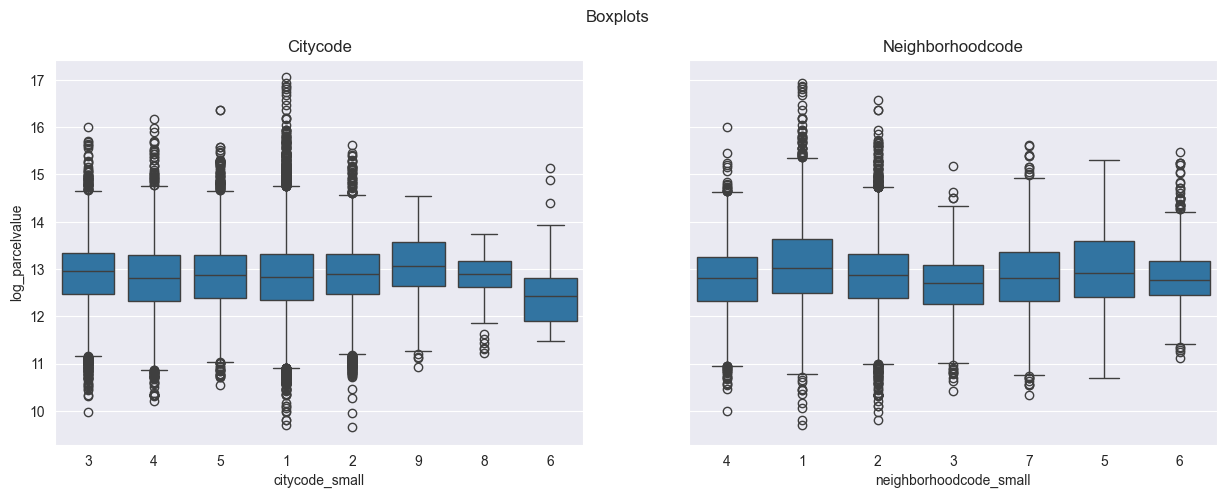

In [177]:
# Check if first digits represent any useful information - Check upto 1, 2 and 3 chars
for df in [train, test]:
    df['citycode_small'] = df['citycode'].apply(lambda x: str(x)[:1] if not np.isnan(x) else x ) #:1,2,3
    df['neighborhoodcode_small'] = df['neighborhoodcode'].apply(lambda x: str(x)[:1] if not np.isnan(x) else x )

# Boxplots for new features
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Boxplots')
## Original
sns.boxplot(ax=axes[0], x = train.citycode_small, y = train.log_parcelvalue)
axes[0].set_title('Citycode')
## Log transformed
sns.boxplot(ax=axes[1], x = train.neighborhoodcode_small, y = train.log_parcelvalue)
axes[1].set_title('Neighborhoodcode')

# Model with Feature Engineering

In [204]:
categorical= ['aircond', 'qualitybuild', 'decktype', 'tubflag', 'heatingtype',
               'taxdelinquencyflag', 'unitnum', 'regioncode', 'has_lot']#,

numerical =   ['basement', 'numbedroom', 'finishedarea',
               'finishedareaEntry', 'numfireplace', 'numfullbath', 'garagenum',
               'garagearea', 'poolnum', 'poolarea', 'roomnum',
               'num34bath', 'year', 'numstories', 'taxyear',
               'taxdelinquencyyear', 'avg_room_size', 'bed_bath_ratio'] #, 'geo_bin_te'

X = train.drop("log_parcelvalue", axis = 1)
y = train[['log_parcelvalue']]
log_tranformer = FunctionTransformer(log_transform,
                                      feature_names_out = "one-to-one")

geo_encoder = TargetEncoder(
    cols = ['geo_bin'],
    smoothing=10,
    handle_missing='value',
    handle_unknown='value',
)

poly_features = ['finishedarea', 'finishedareaEntry' ]

numeric_transformer = Pipeline(
             steps = [
                      ("imputer", SimpleImputer(strategy = 'median')),
                      ("log", log_tranformer),
                      ("scaler", StandardScaler())
                      ])

poly_transformer = Pipeline(
             steps = [
                      ("imputer", SimpleImputer(strategy = 'median')),
                      ("log", log_tranformer),
                      ("poly", PolynomialFeatures(degree = 3, include_bias=False)),
                      ("scaler", StandardScaler())
                      ])

categorical_transformer = Pipeline(
             steps = [ ("imputer", SimpleImputer(strategy = "most_frequent")),
                        ( "ohe", OneHotEncoder(
                                                handle_unknown='ignore',
                                                sparse_output=False))])

# preprocessor pipeline combining both:
preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numerical + ['geo_bin']),
        ("poly", poly_transformer, poly_features),
        ("cat", categorical_transformer, categorical),
        ],
remainder='drop')

# Define the pipeline for preprocessing and the classifier.
regression_pipeline = Pipeline(steps=
                               [('target_encoding', geo_encoder),
                                ('preprocessor', preprocessor),
                                 ('regression', LinearRegression())])

# Check structure of pipeline:
regression_pipeline

Pipeline(steps=[('target_encoding', TargetEncoder(cols=['geo_bin'])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function log_transform at 0x1320509d0>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['basement', 'numbedroom',
                                                   'finished...
                                                                   StandardScaler())]),
                                                  ['finishedarea',
                                                   'finishedareaEntry']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['aircond', 'qualitybuild',
                                                   'decktype', 'tubflag',
                                                   'heatingtype',
                                                   'taxdelinquencyflag',
                                                   'unitnum', 'regioncode',
                                                   'has_lot'])])),
                ('regression', LinearRegression())])

## Simple Regression
## Kaggle Private Score: 572,757
    - Linear Regression performs better in sample, but regularised model performs slightly better on test set.
## In-sample performance: RMSE = 0.5378175037007888


In [205]:
# Get cross validated predictions
columns_used = train[categorical + numerical + ["geo_bin"]].columns.to_list()
y_hat_in = cross_val_predict(regression_pipeline,
                             train[columns_used],
                             y,
                             cv = 5)

# Check in sample RMSE
print(f"RMSE = {root_mean_squared_error(y,y_hat_in)}")

# Fit model
regression_pipeline.fit(train[columns_used], y)

# Predict on test set and undo the logarithmic transformation of target feature
y_hat_test = regression_pipeline.predict(test[columns_used])

# Create datafram of predictions
test_predictions_submit = pd.DataFrame({"lotid": test["lotid"], "parcelvalue": np.exp(y_hat_test[:,0])})

# Dataframe to csv
test_predictions_submit.to_csv("test_predictions_linreg.csv", index = False)

RMSE = 81191072.14036056


In [206]:
models_and_grids = {
    "Lasso": (
        Lasso(max_iter=10000),
        {"model__alpha": [0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.5, 1, 5, 10, 25, 50, 100]}),

    "Ridge": (
        Ridge(),
        {"model__alpha": [0.01, 0.1, 1, 10, 100]}),

    "ElasticNet": (
        ElasticNet(max_iter=10000),
        {
            "model__alpha":     [0.001, 0.01, 0.1, 1, 10],
            "model__l1_ratio":  [0.1, 0.3, 0.5, 0.7, 0.9]
        })}

In [209]:
results = []

for name, (estimator, grid) in models_and_grids.items():

    pipe = Pipeline(steps =
        [('target_encoding', geo_encoder),
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])

    gs = GridSearchCV(
        pipe,
        grid,
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    gs.fit(train[columns_used],
           y)

    best_rmse = -gs.best_score_
    best_params = gs.best_params_

    results.append({
        "model": name,
        "best_params": best_params,
        "rmse": best_rmse
    })
pd.DataFrame(results)

,model,best_params,rmse
0,Lasso,{'model__alpha': 0.001},0.553347
1,Ridge,{'model__alpha': 1},0.537177
2,ElasticNet,"{'model__alpha': 0.001, 'model__l1_ratio': 0.1}",0.542315


### Feature Engineeered Model
### Kaggle Private Score: 571,001
### In-sample performance: 0.5356970293492677

In [210]:
ridge_pipeline = Pipeline(steps=[
    ('target_encoding', geo_encoder),
    ('preprocessor', preprocessor),
    ('Ridge', Ridge(alpha=1))
])
ridge_pipeline.fit(train[columns_used],y)
y_hat_test_ridge = np.exp(ridge_pipeline.predict(test[columns_used]))
test_predictions_submit = pd.DataFrame({"lotid": test["lotid"], "parcelvalue": y_hat_test_ridge[:,0]})
test_predictions_submit.to_csv("test_predictions_FE.csv", index = False)

# Feature Importance:
- The dataset’s region/city/neighborhood codes are anonymous internal IDs, not real geographic units, and cannot be interpreted or validated.
- When one-hot encoded, these high-cardinality codes produced hundreds of sparse features that dominated the linear model’s coefficients through spurious, non-generalizable correlations.
- This inflated their feature importance and caused the model to effectively memorize code-specific price averages, harming interpretability and reliability.
- To avoid this, the codes were dropped in favor of target-encoded spatial features, which capture real geographic variation without relying on arbitrary identifiers.

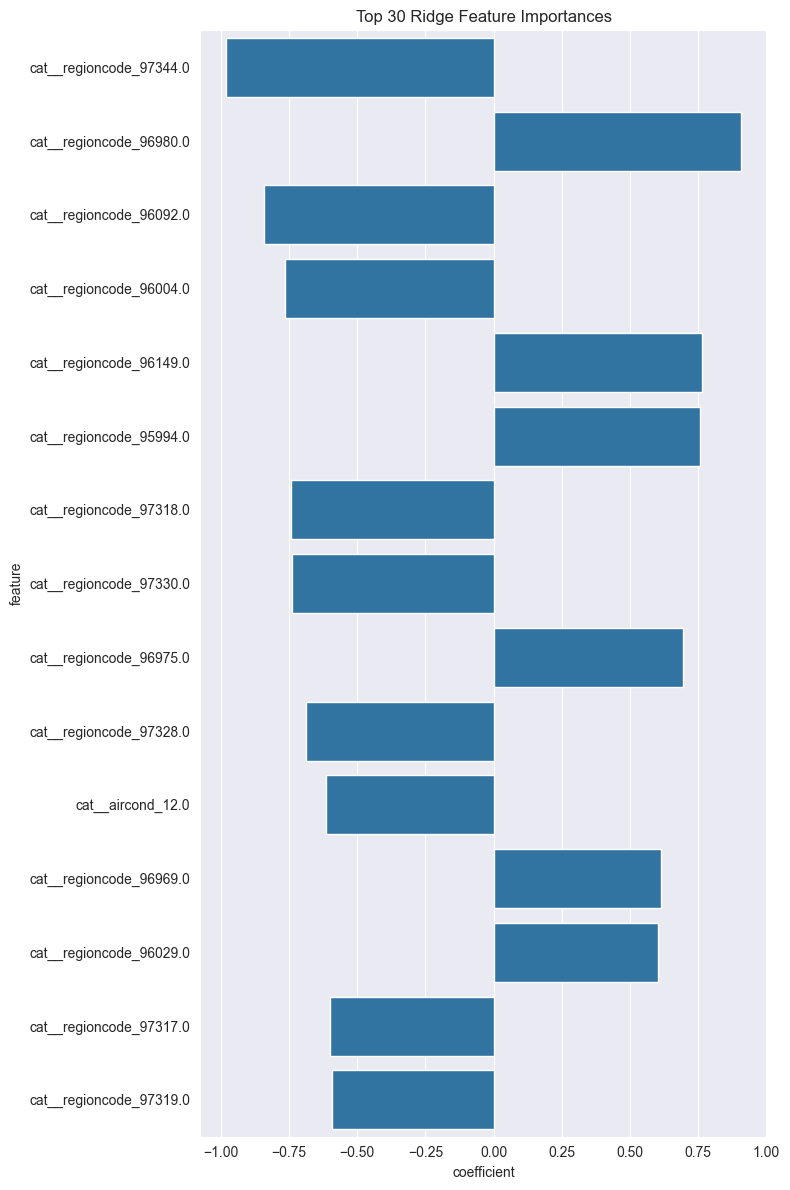

In [211]:
# ridge_pipeline.fit(train[columns_used], y)
coefs = ridge_pipeline.named_steps["Ridge"].coef_
coefs = coefs.ravel()
feature_names = ridge_pipeline.named_steps["preprocessor"].get_feature_names_out()

# DataFrame
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
})

# Sort by importance (abs)
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

# Plot
plt.figure(figsize=(8, 12))
sns.barplot(
    data=coef_df.head(15),
    x="coefficient",
    y="feature"
)
plt.title("Top 30 Ridge Feature Importances")
plt.tight_layout()
plt.show()

# Final model - Region codes are removed
- After removing the high-cardinality location codes, the model no longer latches onto spurious identifiers, so the top coefficients now reflect real housing attributes (e.g., finished area, air conditioning, build quality), which aligns with domain expectations.
- The resulting feature importance ranking is far more interpretable: instead of hundreds of arbitrary region dummies, the model highlights structural, quality, and size-related variables that genuinely drive price variation.
- Test performance improved slightly (≈ 1,000 reduction in RMSE on a 500k scale), indicating that removing the codes primarily enhanced model stability and interpretability, even if the accuracy gain is modest.

In [219]:
# Remove regioncode
categorical= ['aircond', 'qualitybuild', 'decktype', 'tubflag', 'heatingtype',
               'taxdelinquencyflag', 'unitnum', 'has_lot']#,

numerical =   ['basement', 'numbedroom', 'finishedarea',
               'finishedareaEntry', 'numfireplace', 'numfullbath', 'garagenum',
               'garagearea', 'poolnum', 'poolarea', 'roomnum',
               'num34bath', 'year', 'numstories', 'taxyear',
               'taxdelinquencyyear', 'avg_room_size', 'bed_bath_ratio'] #, 'geo_bin_te'

columns_used = train[categorical + numerical + ["geo_bin"]].columns.to_list()


preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numerical + ['geo_bin']),
        ("poly", poly_transformer, poly_features),
        ("cat", categorical_transformer, categorical),
        ],
remainder='drop')


results = []

for name, (estimator, grid) in models_and_grids.items():

    pipe = Pipeline(steps =
        [('target_encoding', geo_encoder),
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])

    gs = GridSearchCV(
        pipe,
        grid,
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )

    gs.fit(train[columns_used],
           y)

    best_rmse = -gs.best_score_
    best_params = gs.best_params_

    results.append({
        "model": name,
        "best_params": best_params,
        "rmse": best_rmse
    })
pd.DataFrame(results)

,model,best_params,rmse
0,Lasso,{'model__alpha': 0.001},0.556104
1,Ridge,{'model__alpha': 0.01},0.554708
2,ElasticNet,"{'model__alpha': 0.001, 'model__l1_ratio': 0.1}",0.555064


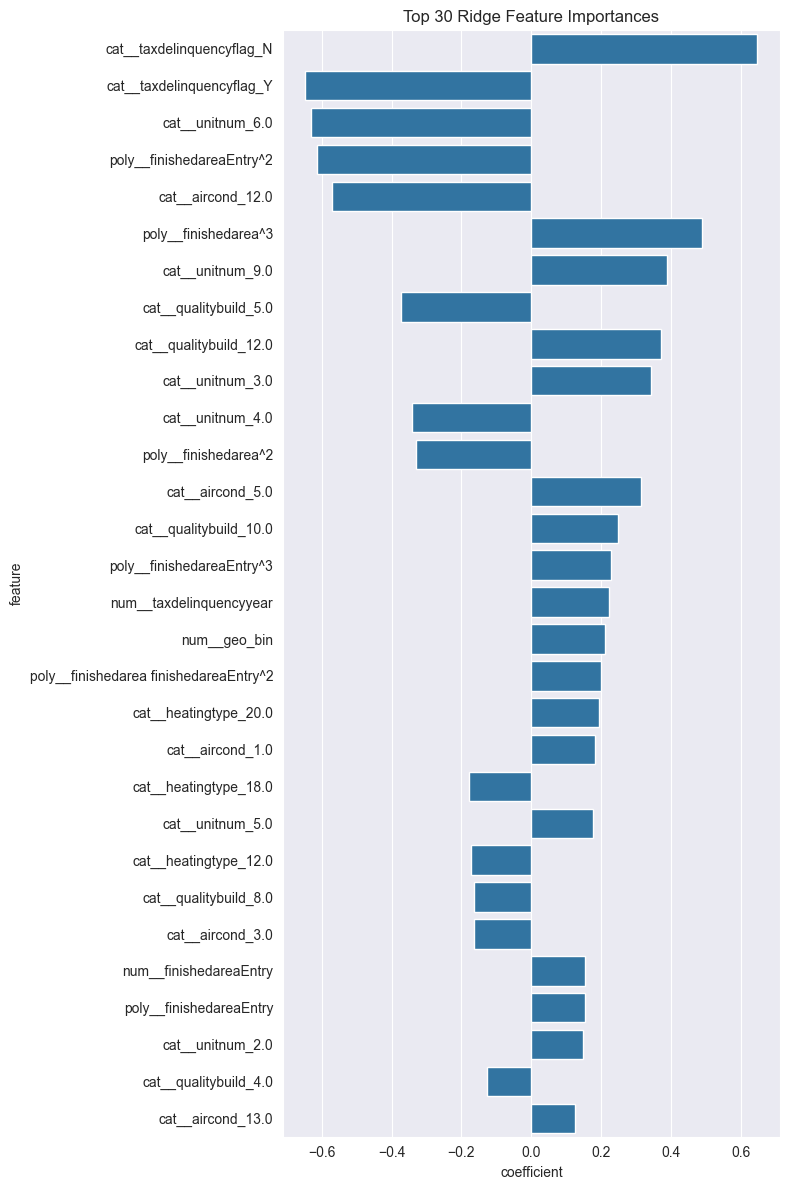

In [221]:
ridge_pipeline = Pipeline(steps=[
    ('target_encoding', geo_encoder),
    ('preprocessor', preprocessor),
    ('Ridge', Ridge(alpha=1))
])

ridge_pipeline.fit(train[columns_used], y)
coefs = ridge_pipeline.named_steps["Ridge"].coef_
coefs = coefs.ravel()
feature_names = ridge_pipeline.named_steps["preprocessor"].get_feature_names_out()

# DataFrame
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
})

# Sort by importance (abs)
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

# Plot
plt.figure(figsize=(8, 12))
sns.barplot(
    data=coef_df.head(30),
    x="coefficient",
    y="feature"
)
plt.title("Top 30 Ridge Feature Importances")
plt.tight_layout()
plt.show()

# Tree-based Models:
- For a quick check, I try fitting a basic XGBoost regression model to check if it performs better than linear models.
- In-sample error = 0.4375, much lower than the linear models.
- However, Kaggle private score = 608,301
- Even without hyperparameter tuning, XGBoost outperformed the baseline linear regression model on both the training and test sets.
- This shows that the dataset contains nonlinear patterns that a boosted-tree model can naturally exploit.
- XGBoost was not tuned, so its performance represents only a “quick baseline” rather than a fully optimized model.

In [192]:
import xgboost as xgb

geo_encoder = TargetEncoder(
    cols = ['geo_bin'],
    smoothing=10,
    handle_missing='value',
    handle_unknown='value',
)

numeric_transformer = Pipeline(
             steps = [
                      ("imputer", SimpleImputer(strategy = 'median'))
                      ])

categorical_transformer = Pipeline(
             steps = [
                 ("imputer", SimpleImputer(strategy = "most_frequent")),
                ( "ohe", OneHotEncoder(
                    handle_unknown='ignore',
                    sparse_output=False))])

# preprocessor pipeline combining both:
preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numerical + ['geo_bin']),
        ("cat", categorical_transformer, categorical),
        ])

# Define the pipeline for preprocessing and the classifier.
xgb_regression_pipeline = Pipeline(steps=[
    ('target_encoding', geo_encoder),
    ('preprocessor', preprocessor),
    ('regression', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        random_state=42))])

# Check structure of pipeline:
xgb_regression_pipeline

Pipeline(steps=[('target_encoding', TargetEncoder(cols=['geo_bin'])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['basement', 'numbedroom',
                                                   'finishedarea',
                                                   'finishedareaEntry',
                                                   'numfireplace',
                                                   'numfullbath', 'garagenum',
                                                   'garagearea', 'poolnum',
                                                   'poolarea', 'roomnum',
                                                   'num34bath', 'year',...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [193]:
xgb_regression_pipeline.fit(train[columns_used], y)
# Get in sampple predictions and RMSE
y_hat_in_xgb = xgb_regression_pipeline.predict(train[columns_used])

# Check in sample RMSE
print(f"RMSE = {root_mean_squared_error(y, y_hat_in_xgb)}") # RMSE = 0.5164723492805274 (log values)

y_hat_test_xgb = np.exp(xgb_regression_pipeline.predict(test[columns_used]))
test_predictions_submit = pd.DataFrame({"lotid": test["lotid"], "parcelvalue": y_hat_test_xgb})
test_predictions_submit.to_csv("test_predictions_xgb.csv", index = False)

RMSE = 0.4375677812736124
